In [1]:
import cv2 as cv
import numpy as np
import matplotlib as plt
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial import distance
#from tqdm import tqdm

In [2]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        if filename != '.DS_Store':
            path = folder + "/" + filename
            for cat in os.listdir(path):
                img = cv.imread(path + "/" + cat,0)

                if img is not None:
                    category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder('./images')
test = load_images_from_folder('./test')

def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)

            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 

    plt.scatter(visual_words[:, 0], visual_words[:, 1], c='red', marker='x')
    plt.xlabel('Feature Dimension 1')
    plt.ylabel('Feature Dimension 2')
    plt.title('K-Means Cluster Centers')
    plt.show()

    return visual_words

def find_index(feature, centers):
    distances = np.linalg.norm(centers - feature, axis=1)
    return np.argmin(distances)

def image_class(all_bovw, centers):
    dict_feature = {}
    for key, value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = 0.0
    class_accuracies = {}

    if results[0] != 0:
        avg_accuracy = (results[1] / results[0]) * 100

    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass-based accuracies: \n")

    for key, value in results[2].items():
        class_accuracy = 0.0

        if value[1] != 0:
            class_accuracy = (value[0] / value[1]) * 100

        class_accuracies[key] = class_accuracy
        print(key + " : %" + str(class_accuracy))

    return avg_accuracy, class_accuracies


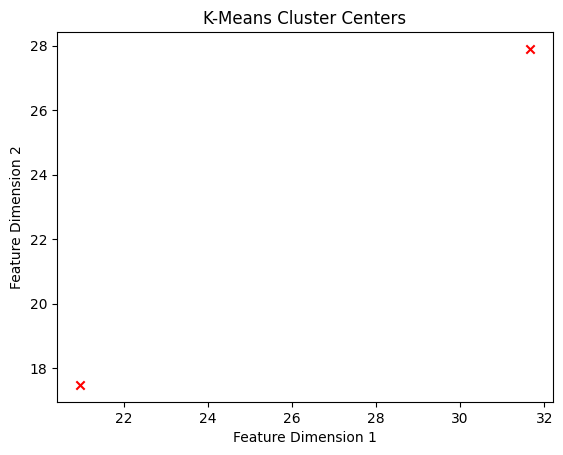

Average accuracy: %99.5

Class-based accuracies: 

.DS_Store : %0.0
hotdog : %99.5
notdog : %99.5


(99.5, {'.DS_Store': 0.0, 'hotdog': 99.5, 'notdog': 99.5})

In [3]:
sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1]

# Takes the central points which is visual words    
visual_words = kmeans(2, descriptor_list) 

# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words)

results_bowl = knn(bovw_train, bovw_test) 
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 